# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [ ]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Answer:**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import LogNorm
import pandas as pd
import cv2
from scipy import fftpack


In [2]:
# Set a seed value (you can use any integer)
seed_value = 42

# Initialize the random number generator with the seed
np.random.seed(seed_value)

In [3]:
mean, cov = np.zeros(2), np.eye(2)   # mean = [0, 0] cov = I2

# create an instance of generator following a normal distribution
# return a 1000 values sample 

rng = np.random.default_rng(seed=42).multivariate_normal(mean, cov, 1000)

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

To find W * where the trajectory crosses the boundary.
On considère 2 points Wn-1 (Xn-1, Yn-1) et Wn (Xn, Yn), avec la norme de Wn>1 et la norme de Wn-1<1. On cherche les coordonnées (x, y) du point d'intersecion entre la droite passant par Wn et Wn-1 et le cercle d'équation (1) x^2 + y^2 = 1.
L'équation de la droite est donnée par (2) y = ax + b avec a = (Yn - Yn-1)/(Xn - Xn-1) et b = Yn-1 - Xn-1*((Yn - Yn-1)/(Xn - Xn-1)).
En mettant (2) au carré on obtient (3) 0 = (a^2 + 1)* x^2 + 2ab * x + b^2 -1, on obtient y en résolvant l'équation (3).

In [25]:
# your code

#this function will be use in the brownian motion function
def verif_racine(x, a, b):
    """"check that x coordonnate of the intersection point is between the x coordate of the last two points"""
    # min and max allow to avoid sign problem
    # treat separatly each root
    if  min(a, b) <= x[0]<= max(a, b) : 
        return x[0]
    if min(a, b) <= x[1]<= max(a, b) :
        return x[1]


def brownian_motion(niter, x, step, rng):
    """simulate the 2D - brownian motion from a gaussian distribution, from a starting point and with a define step"""
    
    # initialize the position of the motion
    W_iter = x
    
    # W is the list to save the coordonates of each point of the random walk
    W = [] 
    

    #loop for each random move of the particule up to niter
    for i in range(1, niter):
        
        #check for each position that the particule is inside the circle(0,1)
        if np.sqrt(W_iter[0]**2 + W_iter[1]**2) < 1:
            #case 1 : the particule is inside the circle
            # stock  the positions of the particule in the list W
            W.append(W_iter)
            # compute the next postion
            W_iter = W_iter + np.sqrt(step)* rng[i]

        
        else:
            #case 1 : the particule is outside the circle
            # retrieve Wn-1 from the list W
            
            # W[-1][1] is the y coordonnate of Wn-1 and W[-1][0] is the x coordonnate of Wn-1
            x_a, x_b, y_a, y_b = W_iter[0],W[-1][0],W_iter[1],W[-1][1]
            
            #calculates the slope (a) and the intercept (b) of the line passing through the last 2 points
            a = (y_a - y_b)/(x_a - x_b)
            b = (x_a * y_b - x_b * y_a)/(x_a - x_b)
            
            # p0, p1, p2 correspond to the coefficients of the degree 2 polynomial obtained in equation (3)
            p = np.empty(3)
            p[2] = b**2 -1
            p[1] = 2 * a * b
            p[0] = a**2 + 1
            x = np.roots(p)
            
            # x must contain 2 root but only one allow to solve our problem
            # always choose the root between X(Wn) X(Wn_1)
            x_possible = verif_racine(x, x_a, x_b)
            
            # compute y coordonate corresponding to x 
            y_possible = a*x_possible + b
            
            # Calculating the L2 (Euclidean) norm
            norme_l2 = np.sqrt(x_possible**2 + y_possible**2)

            # Verify with assert
            assert np.isclose(norme_l2, 1.0), "La norme L2 n'est pas égale à 1"

            # If the norm is equal to 1, the test passes, otherwise an AssertionError is raised.
            print("Le test a réussi : la norme L2 est égale à 1.")
            W.append(W_iter)
            break
            
    return W, (x_possible, y_possible)


In [27]:
# compute the 2D brownian motion with the following niter = 1000, x = [0.2, 0.4], step = 10e-2, rng =rng

rw_W, cross_point = brownian_motion(niter = 1000, x = [0.2, 0.4], step = 10e-2, rng =rng)

Wx = [coordinates[0] for coordinates in rw_W]
Wy = [coordinates[1] for coordinates in rw_W]


Le test a réussi : la norme L2 est égale à 1.


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

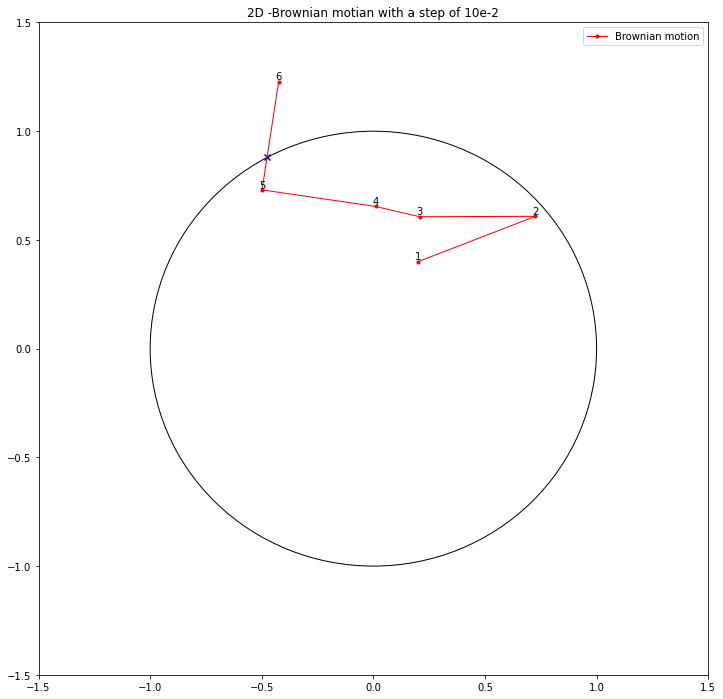

In [32]:
# Creation of an unfilled circle
circle = plt.Circle((0, 0), 1, fill=False)

# Create a figure with a custom size (width x height)
fig = plt.figure(figsize=(12, 12))

# Add circle to axis
ax = fig.add_subplot(111)
ax.add_artist(circle)

# Define axis limit to include circle
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Connect the points inside the circle with a thinner line
plt.plot(Wx, Wy, marker='o', linestyle='-', color='red', markersize=3, linewidth=1, label='Brownian motion')

# Display points inside the circle with numbers and smaller points
for i, (x, y) in enumerate(zip(Wx, Wy), start=1):
    plt.scatter(x, y, c='red', marker='.', s=20)
    plt.text(x, y, str(i), fontsize=10, ha='center', va='bottom')
    
plt.scatter(cross_point[0], cross_point[1], c='blue', marker='x')

# Legend
plt.legend()

# Title
plt.title("2D -Brownian motian with a step of 10e-2")

# Plot the 2 - D brownnian motion
plt.show()



4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

Le test a réussi : la norme L2 est égale à 1.
Le test a réussi : la norme L2 est égale à 1.
Le test a réussi : la norme L2 est égale à 1.
Le test a réussi : la norme L2 est égale à 1.


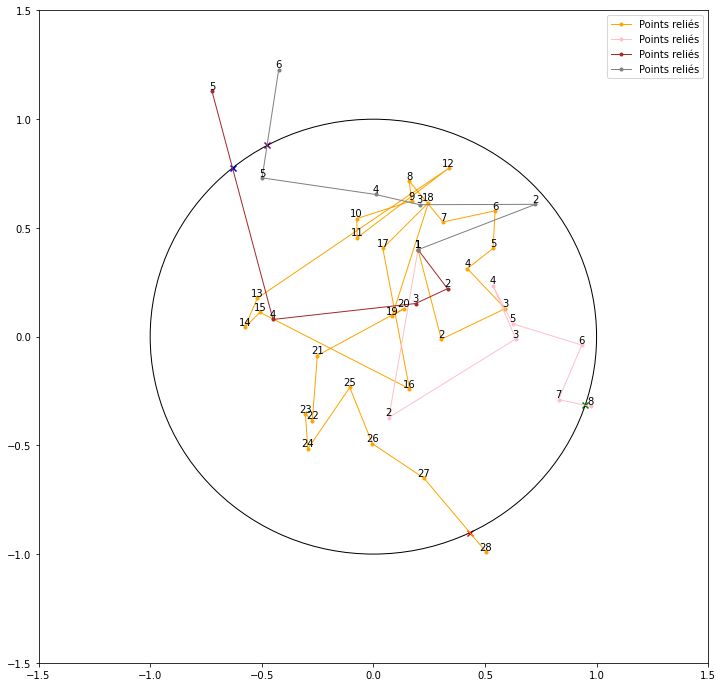

In [26]:
# your code

rng = np.random.default_rng(seed=42).multivariate_normal(mean, cov, 1000)

# Creation of an unfilled circle
circle = plt.Circle((0, 0), 1, fill=False)

# Create a figure with a custom size (width x height)
fig = plt.figure(figsize=(12, 12))

# Add circle to axis
ax = fig.add_subplot(111)
ax.add_artist(circle)

# Define axis limit to include circle
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

colors1 = ['red', 'green', 'blue', 'purple']
colors2 = ['orange', 'pink', 'brown', 'gray']

#for each loop we plot a new random walk

for j in range(4):
    rng = np.random.default_rng(seed=j+1).multivariate_normal(mean, cov, 1000)
    rw_W, cross_point = brownian_motion(niter = 1000, x = [0.2, 0.4], step = 10e-2, rng =rng)
    Wx = [coordinates[0] for coordinates in rw_W]
    Wy = [coordinates[1] for coordinates in rw_W]
    # Connect the pointswith a thinner line
    plt.plot(Wx, Wy, marker='o', linestyle='-', color=colors2[j], markersize=3, linewidth=1, label='Points reliés')

    # Display points
    for i, (x, y) in enumerate(zip(Wx, Wy), start=1):
        plt.scatter(x, y, c=colors2[j], marker='.', s=20)
        plt.text(x, y, str(i), fontsize=10, ha='center', va='bottom')

    plt.scatter(cross_point[0], cross_point[1], color=colors1[j], marker='x')

# Legend
plt.legend()

# Plot the random walk
plt.show()

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

**Answer:**

In [ ]:
# your code

---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

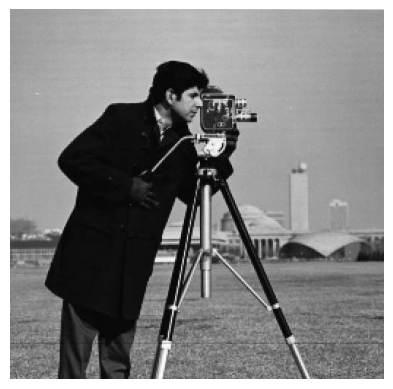

In [3]:
image = cv2.imread("img/cameraman.png")

# Display the image using Matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
plt.axis('off')  # Hide axes
plt.show()

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


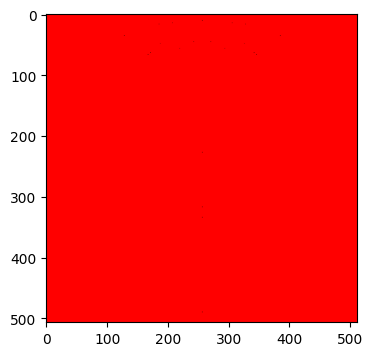

In [4]:
# Compute the 2D discrete Fourier transform (DFT)
dft = np.fft.fft2(image)

spectrum = abs(dft)**2

log_spectrum = np.log(spectrum + 0.0001)

plt.figure(figsize=(12, 4))
plt.imshow(log_spectrum)

plt.show()

a) The output contains the term for zero frequency is in the low-order corner of the transformed axes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


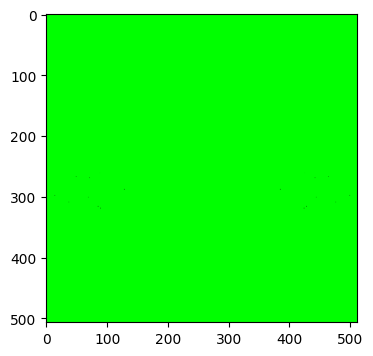

In [5]:
shifted_spectrum = np.fft.fftshift(dft)

spectrum = abs(shifted_spectrum)**2

log_spectrum = np.log(spectrum + 0.0001)

plt.figure(figsize=(12, 4))
plt.imshow(log_spectrum)

plt.show()

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

In [6]:
def ideal_lowpass_filter(img, fx, fy):
    # Compute the 2D discrete Fourier transform (DFT)
    dft = np.fft.fft2(image)
    # Center the spectrum
    shifted_dft = np.fft.fftshift(dft)
    # computer center coordinates
    cx, cy = int(shifted_dft.shape[0]//2), int(shifted_dft.shape[1]//2)
    result = np.zeros(shifted_dft.shape, dtype=complex)
    result[int(cx -fx//2):int(cx +fx//2),int(cy -fy//2):int(cy +fy//2),:] =  shifted_dft[int(cx -fx//2):int(cx +fx//2),int(cy -fy//2):int(cy +fy//2),:]
    # reshift the null frequency to the low-order corner 
    result_shiffted_back = np.fft.ifftshift(result)
    # Computer fourrier transform inverse 
    image_after_filter = np.fft.ifft2(result_shiffted_back).real
    return image_after_filter
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


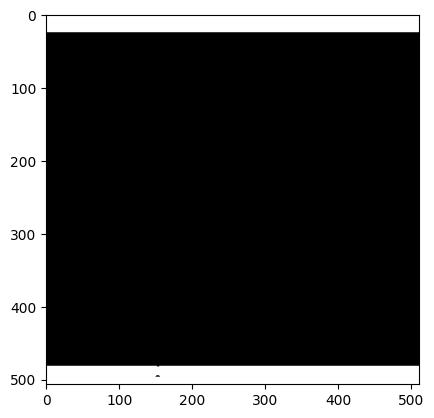

In [7]:
image_post_filter = ideal_lowpass_filter(image, 50,50)

plt.imshow(image_post_filter, cmap= 'gray')  # Convert from BGR to RGB
plt.show()

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

In [ ]:
# your code